Lab 13 

Student ID: 111062201 

Student Name: 林威盛

In [1]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

import keras
from keras import layers

import tensorflow_datasets as tfds

In [2]:
# Feel free to change these parameters according to your system's configuration
# data
dataset_name = "oxford_flowers102"
dataset_repetitions = 5
num_epochs = 20
image_size = 64
suffle_times = 10

# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

In [3]:
end_signal_radian = np.arccos(min_signal_rate)
start_signal_radian = np.arccos(max_signal_rate)

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[1], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPUs


In [5]:
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(suffle_times * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# Load individual datasets
train_part = prepare_dataset("train")
validation_part = prepare_dataset("validation")
test_part = prepare_dataset("test")

# Concatenate all parts into one training dataset
train_dataset = train_part.concatenate(test_part)
val_dataset = validation_part

In [6]:
# @keras.saving.register_keras_serializable()
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID is estimated per batch and is averaged across batches
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        # Use TensorFlow functions instead of ops
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype="float32")
        return (tf.matmul(features_1, tf.transpose(features_2)) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(generated_features, generated_features)
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype="float32")
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(kernel_generated * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()

In [7]:
# @keras.saving.register_keras_serializable()
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.math.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = tf.cast(2.0 * math.pi * frequencies, "float32")
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings


def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same", activation="swish")(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply


def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding, output_shape=(1, 1, 32))(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")

In [ ]:
# @keras.saving.register_keras_serializable()
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # TODO check if the diffusion_times are in the range [0, 1]
        # diffusion_times should be between 0 and 1, corresponding to the start and end of the diffusion process

        diffusion_radian = start_signal_radian + (end_signal_radian - start_signal_radian) * diffusion_times
        
        signal_rates, noise_rates = tf.cos(diffusion_radian), tf.sin(diffusion_radian)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # TODO: implement the denoising network
        # Use the model (self.network or self.ema_network) to predict the noise component in the images

        select_network = self.network if training else self.ema_network
       
        # Predict the noise component and calculate the image component using it
        # Here, use the signal_rate and noise_rate to derive the output components

        pred_noises = select_network([noisy_images, noise_rates ** 2], training=training)
        pred_images = (noisy_images - pred_noises * noise_rates) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            # TODO: implement the reverse diffusion process
            # This process gradually reduces the noise to generate a clearer image

            noisy_images = next_noisy_images # fetch noisy_images

            # sample the diffusion time
            diffusion_times = tf.ones((num_images, 1, 1, 1)) * (1.0 - step * step_size)
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)

            # predict the noise component and the image component
            pred_noises, pred_images = self.denoise(noisy_images, noise_rates, signal_rates, training=False)

            # minx the image and noise components to get the next noisy image
            next_diffusion_time = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(next_diffusion_time)
            next_noisy_images = next_noise_rates * pred_noises + next_signal_rates * pred_images
            
        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(
            shape=(num_images, image_size, image_size, 3)
        )
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.savefig(f"output/{epoch}.png")
        if epoch is not None and epoch % 5 == 4:
            plt.show()
        plt.close()

In [9]:
# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)

In [10]:
import tensorflow_addons as tfa
model.compile(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# model.build(input_shape=(None, image_size, image_size, 3))
# pixelwise mean absolute error is used as loss

In [11]:
# save the best model based on the validation KID metric
checkpoint_path = f"checkpoints/DDIM"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

In [12]:
# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

Epoch 1/20
559/559 [==============================] - 62s 101ms/step - n_loss: 0.2080 - i_loss: 0.4187 - val_n_loss: 0.7889 - val_i_loss: 2.6434 - val_kid: 2.0091
Epoch 2/20
559/559 [==============================] - 50s 89ms/step - n_loss: 0.1659 - i_loss: 0.2843 - val_n_loss: 0.7115 - val_i_loss: 2.2248 - val_kid: 1.8554
Epoch 3/20
559/559 [==============================] - 49s 88ms/step - n_loss: 0.1598 - i_loss: 0.2709 - val_n_loss: 0.5703 - val_i_loss: 1.6672 - val_kid: 1.5136
Epoch 4/20
559/559 [==============================] - 50s 90ms/step - n_loss: 0.1563 - i_loss: 0.2642 - val_n_loss: 0.4245 - val_i_loss: 1.1668 - val_kid: 1.3858
Epoch 5/20
559/559 [==============================] - ETA: 0s - n_loss: 0.1540 - i_loss: 0.2574

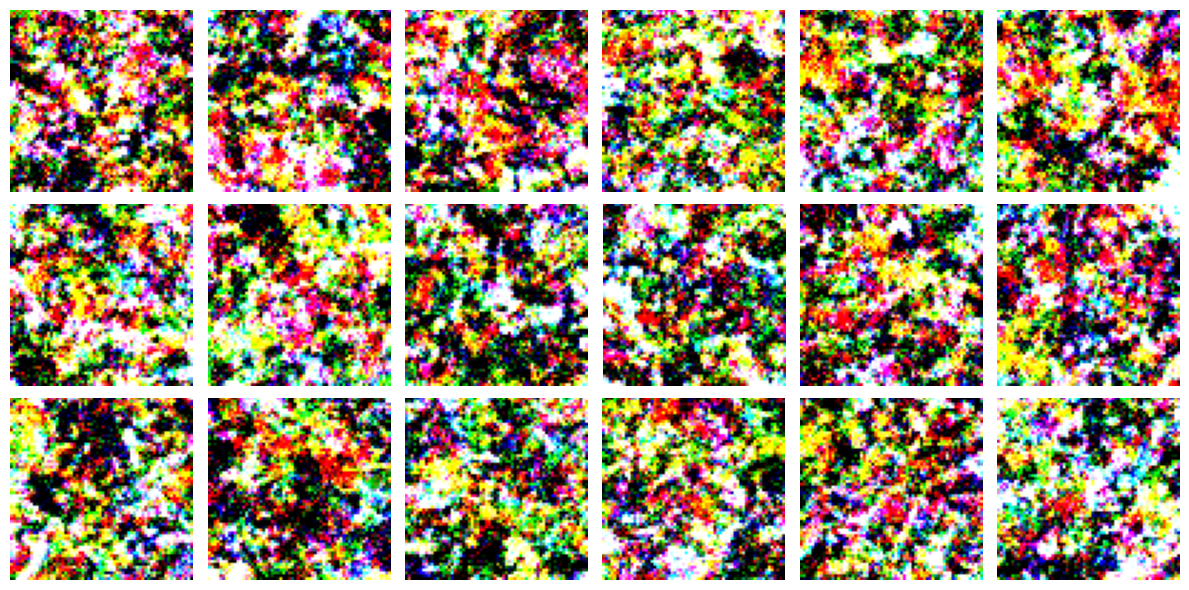

559/559 [==============================] - 49s 88ms/step - n_loss: 0.1540 - i_loss: 0.2574 - val_n_loss: 0.3089 - val_i_loss: 0.7915 - val_kid: 1.5587
Epoch 6/20
559/559 [==============================] - 49s 87ms/step - n_loss: 0.1528 - i_loss: 0.2554 - val_n_loss: 0.2332 - val_i_loss: 0.5534 - val_kid: 1.5707
Epoch 7/20
559/559 [==============================] - 50s 89ms/step - n_loss: 0.1513 - i_loss: 0.2545 - val_n_loss: 0.1899 - val_i_loss: 0.4100 - val_kid: 1.2124
Epoch 8/20
559/559 [==============================] - 50s 89ms/step - n_loss: 0.1508 - i_loss: 0.2506 - val_n_loss: 0.1656 - val_i_loss: 0.3224 - val_kid: 0.9713
Epoch 9/20
559/559 [==============================] - 50s 89ms/step - n_loss: 0.1499 - i_loss: 0.2496 - val_n_loss: 0.1555 - val_i_loss: 0.2753 - val_kid: 0.8402
Epoch 10/20
559/559 [==============================] - ETA: 0s - n_loss: 0.1498 - i_loss: 0.2483

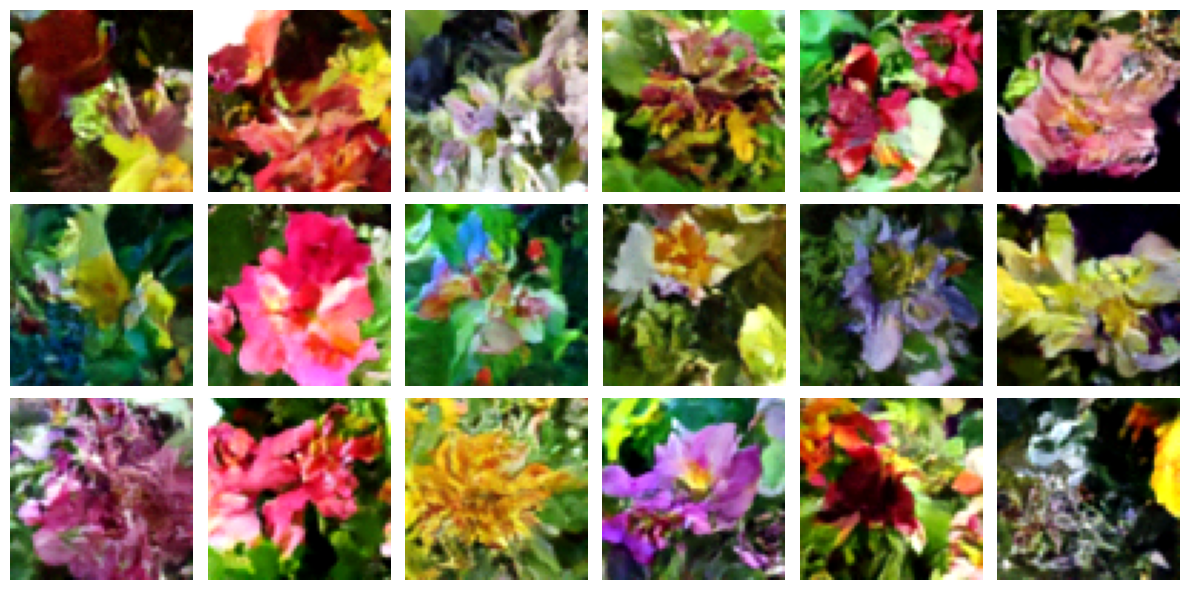

559/559 [==============================] - 50s 90ms/step - n_loss: 0.1498 - i_loss: 0.2483 - val_n_loss: 0.1504 - val_i_loss: 0.2501 - val_kid: 0.7383
Epoch 11/20
559/559 [==============================] - 50s 90ms/step - n_loss: 0.1490 - i_loss: 0.2477 - val_n_loss: 0.1485 - val_i_loss: 0.2430 - val_kid: 0.6060
Epoch 12/20
559/559 [==============================] - 50s 90ms/step - n_loss: 0.1485 - i_loss: 0.2471 - val_n_loss: 0.1468 - val_i_loss: 0.2409 - val_kid: 0.4599
Epoch 13/20
559/559 [==============================] - 50s 90ms/step - n_loss: 0.1477 - i_loss: 0.2478 - val_n_loss: 0.1459 - val_i_loss: 0.2366 - val_kid: 0.3874
Epoch 14/20
559/559 [==============================] - 49s 89ms/step - n_loss: 0.1472 - i_loss: 0.2464 - val_n_loss: 0.1461 - val_i_loss: 0.2337 - val_kid: 0.3525
Epoch 15/20
559/559 [==============================] - ETA: 0s - n_loss: 0.1479 - i_loss: 0.2453

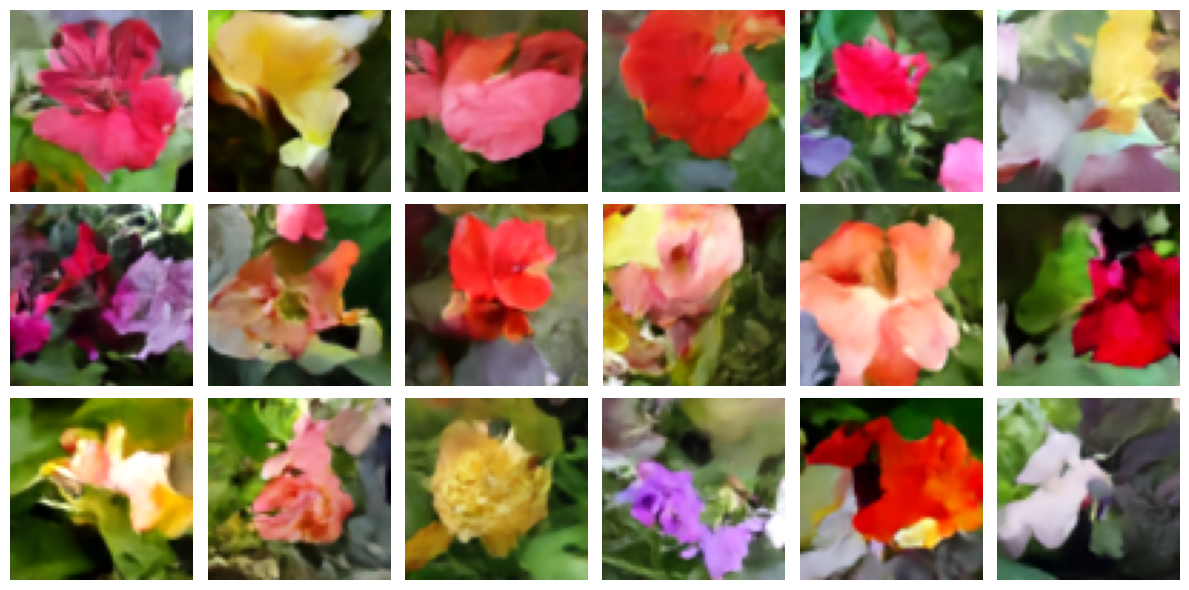

559/559 [==============================] - 50s 89ms/step - n_loss: 0.1479 - i_loss: 0.2453 - val_n_loss: 0.1447 - val_i_loss: 0.2351 - val_kid: 0.3278
Epoch 16/20
559/559 [==============================] - 50s 90ms/step - n_loss: 0.1474 - i_loss: 0.2453 - val_n_loss: 0.1459 - val_i_loss: 0.2321 - val_kid: 0.3153
Epoch 17/20
559/559 [==============================] - 50s 89ms/step - n_loss: 0.1472 - i_loss: 0.2443 - val_n_loss: 0.1457 - val_i_loss: 0.2306 - val_kid: 0.3115
Epoch 18/20
559/559 [==============================] - 50s 89ms/step - n_loss: 0.1468 - i_loss: 0.2447 - val_n_loss: 0.1448 - val_i_loss: 0.2325 - val_kid: 0.3040
Epoch 19/20
559/559 [==============================] - 50s 89ms/step - n_loss: 0.1459 - i_loss: 0.2448 - val_n_loss: 0.1453 - val_i_loss: 0.2316 - val_kid: 0.2861
Epoch 20/20
559/559 [==============================] - ETA: 0s - n_loss: 0.1463 - i_loss: 0.2445

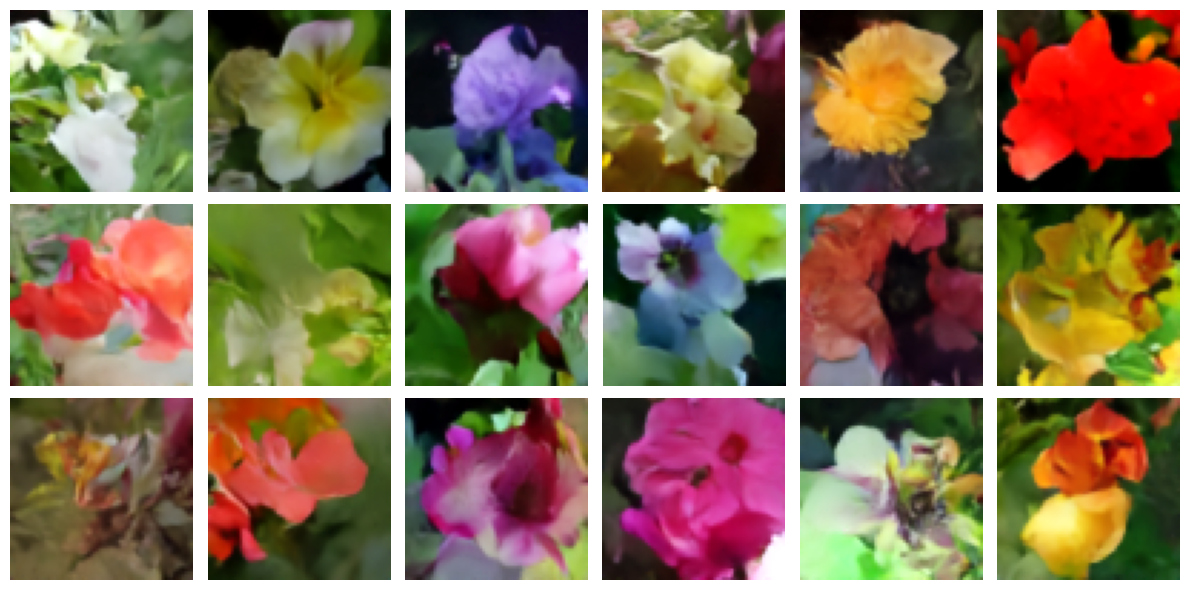

559/559 [==============================] - 50s 89ms/step - n_loss: 0.1463 - i_loss: 0.2445 - val_n_loss: 0.1431 - val_i_loss: 0.2351 - val_kid: 0.2861


In [13]:
# run training and plot generated images periodically
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=num_epochs,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

## Inference

In [14]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()

## Summary

For diffusion_schedule, I use sin and cos function to present noise_rates and signal_rates.
And, to denote the time, select the network dependent on training or not, then predict compoenents by the network and noise_rates, signal_rates.
Lastly, use a for-loop to iteratively predict noise, merge it into the image component, then update next_noisy_images, and fetch it at the begnning of the next iteration.
